## 공원 데이터 EDA

##파일 불러오기 및 전처리

In [1]:
import pandas as pd
import numpy as np
import folium
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from folium.plugins import MarkerCluster
from IPython.display import display, HTML

In [2]:
!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 123598 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

파일 불러오기

In [3]:
park=pd.read_csv("/content/drive/MyDrive/EDA 프로젝트 도시환경/공원 최종 데이터_진짜최종.csv",encoding='cp949')
pop=pd.read_csv("/content/drive/MyDrive/EDA 프로젝트 도시환경/인구.csv",encoding='cp949')

In [4]:
#불필요한 column 삭제
park=park.drop(['관리번호','소재지도로명주소','소재지지번주소','전화번호','데이터기준일자','Unnamed: 17'],axis=1)

행정구역 통일 시키기

In [ ]:
#행정구역 통일 시키기

def process_address(address):
    if pd.isna(address):
        return address
    address = str(address)

    # 광역시, 서울특별시, 세종특별자치시 처리
    if '광역시' in address or '서울특별시' in address or '세종특별자치시' in address:
        match = re.match(r'^.*시\s.*구', address)
        if match:
            return match.group()
        match = re.match(r'^.*시', address)  # 세종특별자치시는 '구'가 없음
        if match:
            return match.group()
    # 도 단위 처리
    else:
        match = re.match(r'^.*도\s.*시', address)
        if match:
            return match.group()
    return address

# 소재지지번주소 열에 대해 전처리 수행
park['소재지지번주소'] = park['소재지지번주소'].apply(process_address)

In [5]:
park=park.rename(columns={'전처리된주소':'행정자치구역'})
park.head()

,공원명,공원구분,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,행정자치구역
0,봉화산2지구2(3호),근린공원,37.353826,127.921297,33036.0,NaN,NaN,NaN,NaN,NaN,2009-11-20,강원도 원주시청,강원도 원주시
1,단구공원,근린공원,37.326433,127.953644,290813.0,농구장+배드민턴장,NaN,NaN,NaN,NaN,1967-04-19,강원도 원주시청,강원도 원주시
2,호국(태장2호)공원,근린공원,37.365319,127.952681,33539.0,NaN,NaN,NaN,NaN,NaN,1967-04-19,강원도 원주시청,강원도 원주시
3,단계조각(단계3호)공원,근린공원,37.340966,127.935690,22216.0,풋살경기장,NaN,NaN,청소년도서관+체육관,NaN,1974-11-26,강원도 원주시청,강원도 원주시
4,일산공원,근린공원,37.346851,127.937280,21182.0,NaN,NaN,NaN,NaN,NaN,1974-11-26,강원도 원주시청,강원도 원주시


행정자치구역->시도별로 바꾸기

In [6]:
#행정구역 시도별로 바꾸기

def simplify_address(address):
    # 정규 표현식을 사용하여 '도', '특별시', '광역시' 기준으로 자르기
    match = re.match(r'^(.*?도|.*?특별시|.*?광역시)', address)
    if match:
        return match.group(1)
    return address

# NaN 값을 빈 문자열로 대체
park['행정자치구역'] = park['행정자치구역'].fillna('')

# 새로운 열 추가
park['시도별'] = park['행정자치구역'].apply(simplify_address)

In [7]:
park['시도별']=park['시도별'].str.replace('수원시 권선구','경기도')
park['시도별']=park['시도별'].str.replace('대구광역시 달서구 도','대구광역시')
park['시도별']=park['시도별'].str.replace('부산광역시 영도','부산광역시')
park['시도별']=park['시도별'].str.replace('서울특별시 도','서울특별시')
park= park.dropna(subset=['시도별'])

In [ ]:
park.head()

,공원명,공원구분,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,행정자치구역,시도별
0,봉화산2지구2(3호),근린공원,37.353826,127.921297,33036.0,NaN,NaN,NaN,NaN,NaN,2009-11-20,강원도 원주시청,강원도 원주시,강원도
1,단구공원,근린공원,37.326433,127.953644,290813.0,농구장+배드민턴장,NaN,NaN,NaN,NaN,1967-04-19,강원도 원주시청,강원도 원주시,강원도
2,호국(태장2호)공원,근린공원,37.365319,127.952681,33539.0,NaN,NaN,NaN,NaN,NaN,1967-04-19,강원도 원주시청,강원도 원주시,강원도
3,단계조각(단계3호)공원,근린공원,37.340966,127.935690,22216.0,풋살경기장,NaN,NaN,청소년도서관+체육관,NaN,1974-11-26,강원도 원주시청,강원도 원주시,강원도
4,일산공원,근린공원,37.346851,127.937280,21182.0,NaN,NaN,NaN,NaN,NaN,1974-11-26,강원도 원주시청,강원도 원주시,강원도


공원보유시설 하나로 합치기 + 개수로 변환

In [8]:
def combine_facilities(row):
    facilities = []
    columns = ['공원보유시설(운동시설)', '공원보유시설(유희시설)', '공원보유시설(편익시설)', '공원보유시설(교양시설)', '공원보유시설(기타시설)']
    for col in columns:
        if pd.notna(row[col]):
            facilities.append(row[col])
    return '+'.join(facilities)

# 새로운 열 추가
park['공원시설통합'] = park.apply(combine_facilities, axis=1)

In [9]:
def count_facilities(facilities):
    if facilities:
        return facilities.count('+') + 1  # '+'의 개수 + 1이 시설의 개수
    return 0

# 새로운 열 추가 (통합시설 개수)
park['공원시설통합num'] = park['공원시설통합'].apply(count_facilities)

In [ ]:
park.head()

,공원명,공원구분,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,행정자치구역,시도별,공원시설통합,공원시설통합num
0,봉화산2지구2(3호),근린공원,37.353826,127.921297,33036.0,NaN,NaN,NaN,NaN,NaN,2009-11-20,강원도 원주시청,강원도 원주시,강원도,,0
1,단구공원,근린공원,37.326433,127.953644,290813.0,농구장+배드민턴장,NaN,NaN,NaN,NaN,1967-04-19,강원도 원주시청,강원도 원주시,강원도,농구장+배드민턴장,2
2,호국(태장2호)공원,근린공원,37.365319,127.952681,33539.0,NaN,NaN,NaN,NaN,NaN,1967-04-19,강원도 원주시청,강원도 원주시,강원도,,0
3,단계조각(단계3호)공원,근린공원,37.340966,127.935690,22216.0,풋살경기장,NaN,NaN,청소년도서관+체육관,NaN,1974-11-26,강원도 원주시청,강원도 원주시,강원도,풋살경기장+청소년도서관+체육관,3
4,일산공원,근린공원,37.346851,127.937280,21182.0,NaN,NaN,NaN,NaN,NaN,1974-11-26,강원도 원주시청,강원도 원주시,강원도,,0


In [10]:
# Replace empty strings with NaN in the '시도별' column
park['시도별'].replace('', pd.NA, inplace=True)

# Remove rows where '시도별' is NaN
park.dropna(subset=['시도별'], inplace=True)

# Convert '지정고시일' to datetime format
park['지정고시일'] = pd.to_datetime(park['지정고시일'], errors='coerce')

# Calculate the average designation date by '시도별'
average_designation_date = park.groupby('시도별')['지정고시일'].mean().reset_index()

# Extract the year from the average designation date
average_designation_date['평균년도'] = average_designation_date['지정고시일'].dt.year

# Merge the average year back into the original park DataFrame
park = park.merge(average_designation_date[['시도별', '평균년도']], on='시도별', how='left')

# Display the updated park DataFrame
park.head()

,공원명,공원구분,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,행정자치구역,시도별,공원시설통합,공원시설통합num,평균년도
0,봉화산2지구2(3호),근린공원,37.353826,127.921297,33036.0,NaN,NaN,NaN,NaN,NaN,2009-11-20,강원도 원주시청,강원도 원주시,강원도,,0,1999
1,단구공원,근린공원,37.326433,127.953644,290813.0,농구장+배드민턴장,NaN,NaN,NaN,NaN,1967-04-19,강원도 원주시청,강원도 원주시,강원도,농구장+배드민턴장,2,1999
2,호국(태장2호)공원,근린공원,37.365319,127.952681,33539.0,NaN,NaN,NaN,NaN,NaN,1967-04-19,강원도 원주시청,강원도 원주시,강원도,,0,1999
3,단계조각(단계3호)공원,근린공원,37.340966,127.935690,22216.0,풋살경기장,NaN,NaN,청소년도서관+체육관,NaN,1974-11-26,강원도 원주시청,강원도 원주시,강원도,풋살경기장+청소년도서관+체육관,3,1999
4,일산공원,근린공원,37.346851,127.937280,21182.0,NaN,NaN,NaN,NaN,NaN,1974-11-26,강원도 원주시청,강원도 원주시,강원도,,0,1999


##데이터 합치기

In [11]:
park[['시도별', '행정구']] = park['행정자치구역'].str.split(n=1, expand=True)

# 필요한 통계 계산
data_grouped = park.groupby(['시도별', '행정구']).agg(
    공원수=('공원명', 'count'),
    평균위도=('위도', 'mean'),
    평균경도=('경도', 'mean'),
    평균공원면적=('공원면적', 'mean'),
    공원시설통합num평균=('공원시설통합num', 'mean'),
    평균년도=('지정고시일', lambda x: pd.to_datetime(x, errors='coerce').dt.year.mean())
).reset_index()

# 결과 확인
print(data_grouped.head())

   시도별  행정구  공원수       평균위도        평균경도        평균공원면적  공원시설통합num평균  \
0  강원도  강릉시   86  37.777317  128.889807  13823.427907     0.000000   
1  강원도  고성군   29  38.356254  128.488020   9285.931034     3.034483   
2  강원도  동해시    5  37.530342  129.116651   8255.000000     0.000000   
3  강원도  삼척시   23  37.381016  129.191656  19173.739130     3.521739   
4  강원도  속초시   32  38.195861  128.584326  19104.812500     5.531250   

          평균년도  
0  1998.903226  
1  1999.200000  
2  1990.000000  
3  1990.043478  
4  1993.343750  


In [12]:
data_grouped

,시도별,행정구,공원수,평균위도,평균경도,평균공원면적,공원시설통합num평균,평균년도
0,강원도,강릉시,86,37.777317,128.889807,13823.427907,0.000000,1998.903226
1,강원도,고성군,29,38.356254,128.488020,9285.931034,3.034483,1999.200000
2,강원도,동해시,5,37.530342,129.116651,8255.000000,0.000000,1990.000000
3,강원도,삼척시,23,37.381016,129.191656,19173.739130,3.521739,1990.043478
4,강원도,속초시,32,38.195861,128.584326,19104.812500,5.531250,1993.343750
...,...,...,...,...,...,...,...,...
221,충청북도,제천시,66,37.137013,128.197206,8769.169470,5.863636,1995.045455
222,충청북도,증평군,30,36.788564,127.590175,8534.633333,1.500000,2004.666667
223,충청북도,진천군,36,36.907818,127.500353,23364.822222,9.222222,2005.388889
224,충청북도,청주시,433,36.523821,127.399890,35281.694457,0.000000,1999.759815


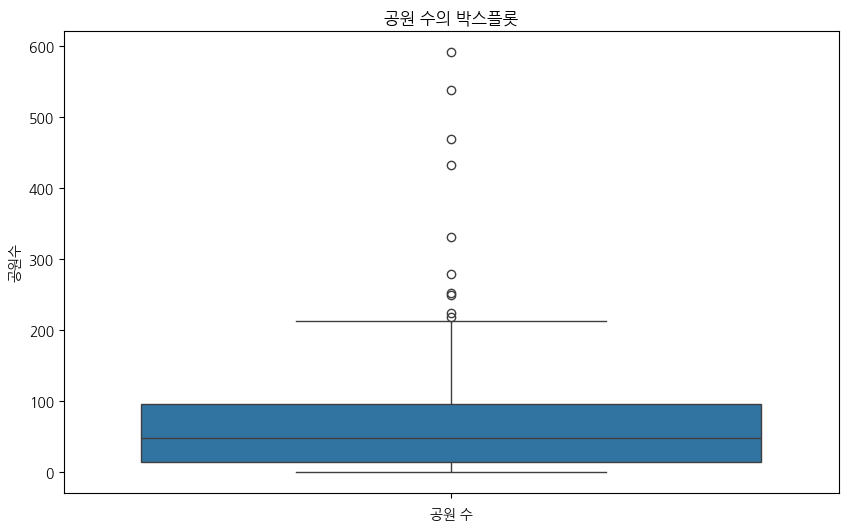

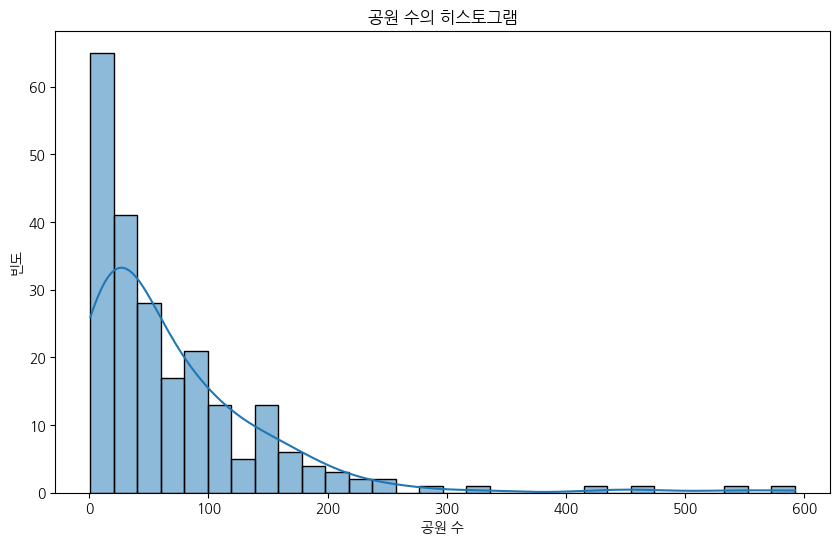

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
# data = pd.read_csv('파일 경로 또는 URL')

# 공원 수에 대한 박스플롯 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(data_grouped['공원수'])
plt.title('공원 수의 박스플롯')
plt.xlabel('공원 수')
plt.show()

# 공원 수에 대한 히스토그램 그리기
plt.figure(figsize=(10, 6))
sns.histplot(data_grouped['공원수'], bins=30, kde=True)  # KDE는 커널 밀도 추정치를 추가하여 히스토그램을 부드럽게 표현합니다.
plt.title('공원 수의 히스토그램')
plt.xlabel('공원 수')
plt.ylabel('빈도')
plt.show()

In [13]:
abbreviations = {
    "서울특별시": "서울",
    "경기도": "경기",
    "강원도": "강원",
    "충청북도": "충북",
    "충청남도": "충남",
    "전라북도": "전북",
    "전라남도": "전남",
    "경상북도": "경북",
    "경상남도": "경남",
    "제주특별자치도": "제주",
    "부산광역시": "부산",
    "대구광역시": "대구",
    "인천광역시": "인천",
    "광주광역시": "광주",
    "대전광역시": "대전",
    "울산광역시": "울산"
}

# 이미 생성된 data_grouped에서 '시도별' 칼럼 업데이트
data_grouped['시도별'] = data_grouped['시도별'].map(abbreviations).fillna(data_grouped['시도별'])


In [ ]:
data_grouped.to_csv("/content/drive/MyDrive/EDA 프로젝트 도시환경/공원데이터통합",index=False, encoding='utf-8-sig')

In [ ]:
# '행정자치구역'을 공백으로 분리하되, 최대 두 부분으로만 분리
split_data = park['행정자치구역'].str.split(n=1, expand=True)
park['시도별'] = split_data[0]
park['행정구'] = split_data[1]

# 세종특별자치시의 경우 행정구 칼럼을 None으로 설정
park['행정구'] = park.apply(lambda x: x['행정구'] if x['시도별'] != '세종특별자치시' else None, axis=1)

# 시도 이름 축약
abbreviations = {
    "서울특별시": "서울",
    "경기도": "경기",
    "강원도": "강원",
    "충청북도": "충북",
    "충청남도": "충남",
    "전라북도": "전북",
    "전라남도": "전남",
    "경상북도": "경북",
    "경상남도": "경남",
    "제주특별자치도": "제주",
    "부산광역시": "부산",
    "대구광역시": "대구",
    "인천광역시": "인천",
    "광주광역시": "광주",
    "대전광역시": "대전",
    "울산광역시": "울산",
    "세종특별자치시": "세종"
}

park['시도별'] = park['시도별'].map(abbreviations).fillna(park['시도별'])

# 필요한 통계 계산
park_fin = park.groupby(['시도별', '행정구']).agg(
    공원수=('공원명', 'count'),
    평균공원면적=('공원면적', 'mean'),
    공원시설통합num평균=('공원시설통합num', 'mean'),
    평균년도=('지정고시일', lambda x: pd.to_datetime(x, errors='coerce').dt.year.mean())
).reset_index()


In [ ]:
park_fin

,시도별,행정구,공원수,평균공원면적,공원시설통합num평균,평균년도
0,강원,강릉시,86,13823.427907,0.000000,1998.903226
1,강원,고성군,29,9285.931034,3.034483,1999.200000
2,강원,동해시,5,8255.000000,0.000000,1990.000000
3,강원,삼척시,23,19173.739130,3.521739,1990.043478
4,강원,속초시,32,19104.812500,5.531250,1993.343750
...,...,...,...,...,...,...
221,충북,제천시,66,8769.169470,5.863636,1995.045455
222,충북,증평군,30,8534.633333,1.500000,2004.666667
223,충북,진천군,36,23364.822222,9.222222,2005.388889
224,충북,청주시,433,35281.694457,0.000000,1999.759815


In [ ]:
park_fin.to_csv("/content/drive/MyDrive/EDA 프로젝트 도시환경/공원데이터통합최종.csv",index=False)

In [ ]:
# 세종특별자치시에 해당하는 데이터만 필터링
sejong_data = park[park['행정자치구역'] == '세종특별자치시']

# 세종특별자치시 통계 계산
sejong_stats = {
    '공원수': sejong_data['공원명'].count(),
    '평균공원면적': sejong_data['공원면적'].mean(),
    '공원시설통합num평균': sejong_data['공원시설통합num'].mean(),
    '평균년도': pd.to_datetime(sejong_data['지정고시일'], errors='coerce').dt.year.mean()
}

# 결과 출력
print("세종특별자치시 통계:")
print(f"공원수: {sejong_stats['공원수']}")
print(f"평균공원면적: {sejong_stats['평균공원면적']:.2f}")
print(f"공원시설통합num평균: {sejong_stats['공원시설통합num평균']:.2f}")
print(f"평균년도: {sejong_stats['평균년도']:.0f}")

세종특별자치시 통계:
공원수: 165
평균공원면적: 20498.33
공원시설통합num평균: 4.39
평균년도: 2006


## 지도 시각화

In [ ]:
m = folium.Map(location=[37.563383, 126.996039], zoom_start=12, tiles='cartodbpositron')

park_map=park[['공원구분','위도','경도','공원면적']]
park_types=park['공원구분'].unique()

#colors = plt.cm.get_cmap('tab20', len(park_types))
#color_map = {park_type: f'#{int(colors(i)[:3][0]*255):02x}{int(colors(i)[:3][1]*255):02x}{int(colors(i)[:3][2]*255):02x}' for i, park_type in enumerate(park_types)}

colors = plt.cm.get_cmap('nipy_spectral', len(park_types))
color_map = {park_type: f'#{int(colors(i)[:3][0]*255):02x}{int(colors(i)[:3][1]*255):02x}{int(colors(i)[:3][2]*255):02x}' for i, park_type in enumerate(park_types)}

max_area = park['공원면적'].max()
min_area = park['공원면적'].min()

marker_cluster = MarkerCluster().add_to(m)

for _, row in park_map.iterrows():
    park_type = row['공원구분']
    latitude = row['위도']
    longitude = row['경도']
    area=row['공원면적']
    radius = (area - min_area) / (max_area - min_area) * 20 + 5
    color = color_map.get(park_type, '#000000')  # 색상 매핑, 기본값은 검정색

    folium.CircleMarker(
        location=[latitude, longitude],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6
    ).add_to(marker_cluster)

legend_html = '<div style="position: fixed; bottom: 50px; left: 50px; width: 150px; height: auto; background-color: white; z-index:9999; font-size:14px;">'
legend_html += '<b>공원 구분 색상 범례</b><br>'
for park_type, color in color_map.items():
    legend_html += f'<i style="background:{color}; width: 20px; height: 20px; float: left; margin-right: 8px;"></i>{park_type}<br>'
legend_html += '</div>'

m.get_root().html.add_child(folium.Element(legend_html))

display(m)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 기본 지도 생성
m = folium.Map(location=[37.563383, 126.996039], zoom_start=12, tiles='cartodbpositron')

# 공원 데이터에서 필요한 열만 추출
park_map = park[['공원구분', '위도', '경도', '공원면적']]
park_types = park['공원구분'].unique()

# 색상 매핑
colors = plt.cm.Spectral(np.linspace(0, 1, len(park_types)))
color_map = {park_type: f'#{int(c[0]*255):02x}{int(c[1]*255):02x}{int(c[2]*255):02x}' for park_type, c in zip(park_types, colors)}

# 개별 점 추가
for _, row in park_map.iterrows():
    park_type = row['공원구분']
    latitude = row['위도']
    longitude = row['경도']
    visitors = int(row['공원면적'])  # 방문자 수에 따라 점을 반복해서 추가

    for _ in range(visitors // 1000):  # 1000명 당 하나의 점으로 비례하여 표시
        folium.CircleMarker(
            location=[latitude, longitude],
            radius=1,  # 점 크기
            color=color_map[park_type],  # 유형별 색상
            fill=True,
            fill_color=color_map[park_type],
            fill_opacity=0.5
        ).add_to(m)

display(m)

KeyError: "['방문자수'] not in index"

## 공원 수 시각화

시도별 공원수 그래프 (+공원종류 구분)

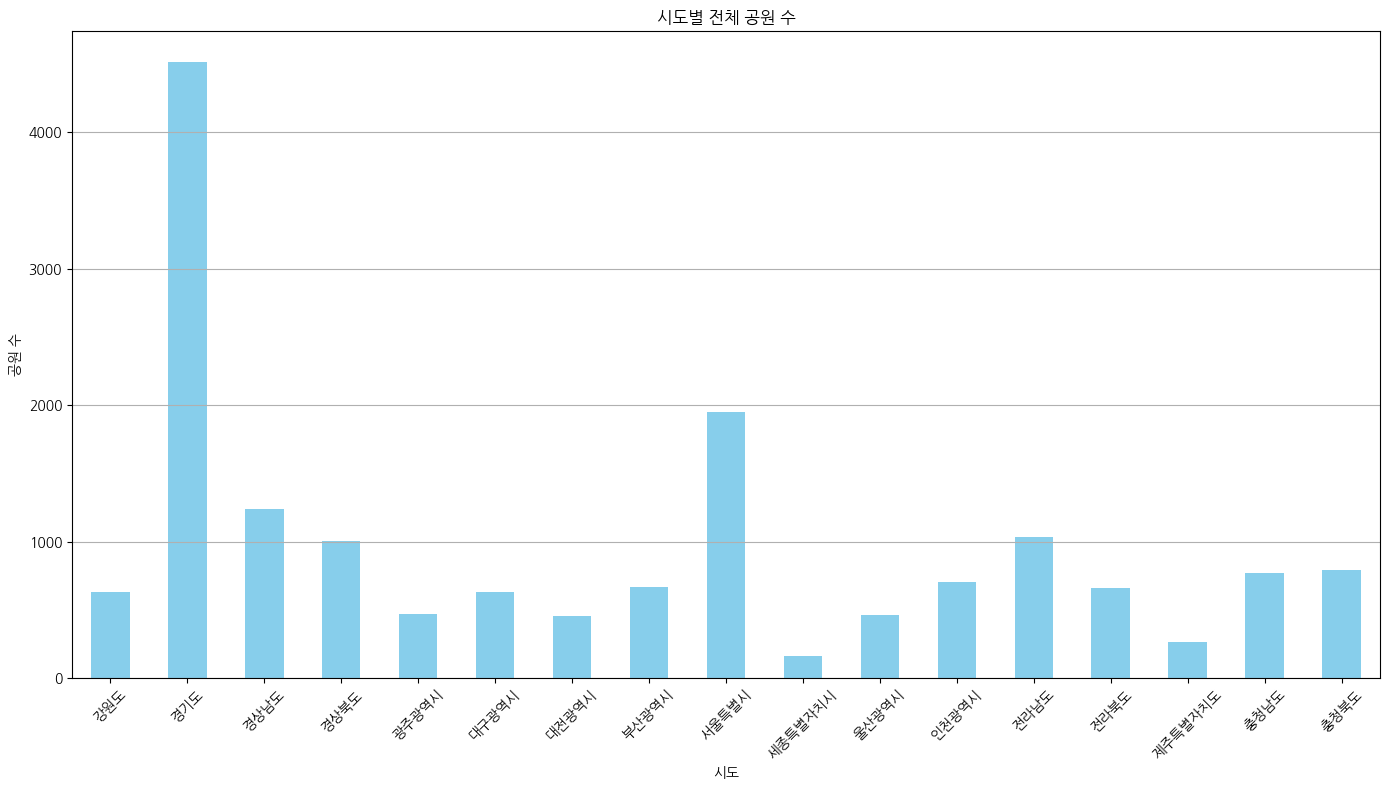

In [ ]:
#시도별 공원수
park['시도별'].replace('', pd.NA, inplace=True)

# NaN 값 제거
park.dropna(subset=['시도별'], inplace=True)

# 시도별 전체 공원 수 계산
total_park_counts = park['시도별'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(14, 8))
total_park_counts.plot(kind='bar', color='skyblue')

plt.xlabel('시도')
plt.ylabel('공원 수')
plt.title('시도별 전체 공원 수')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

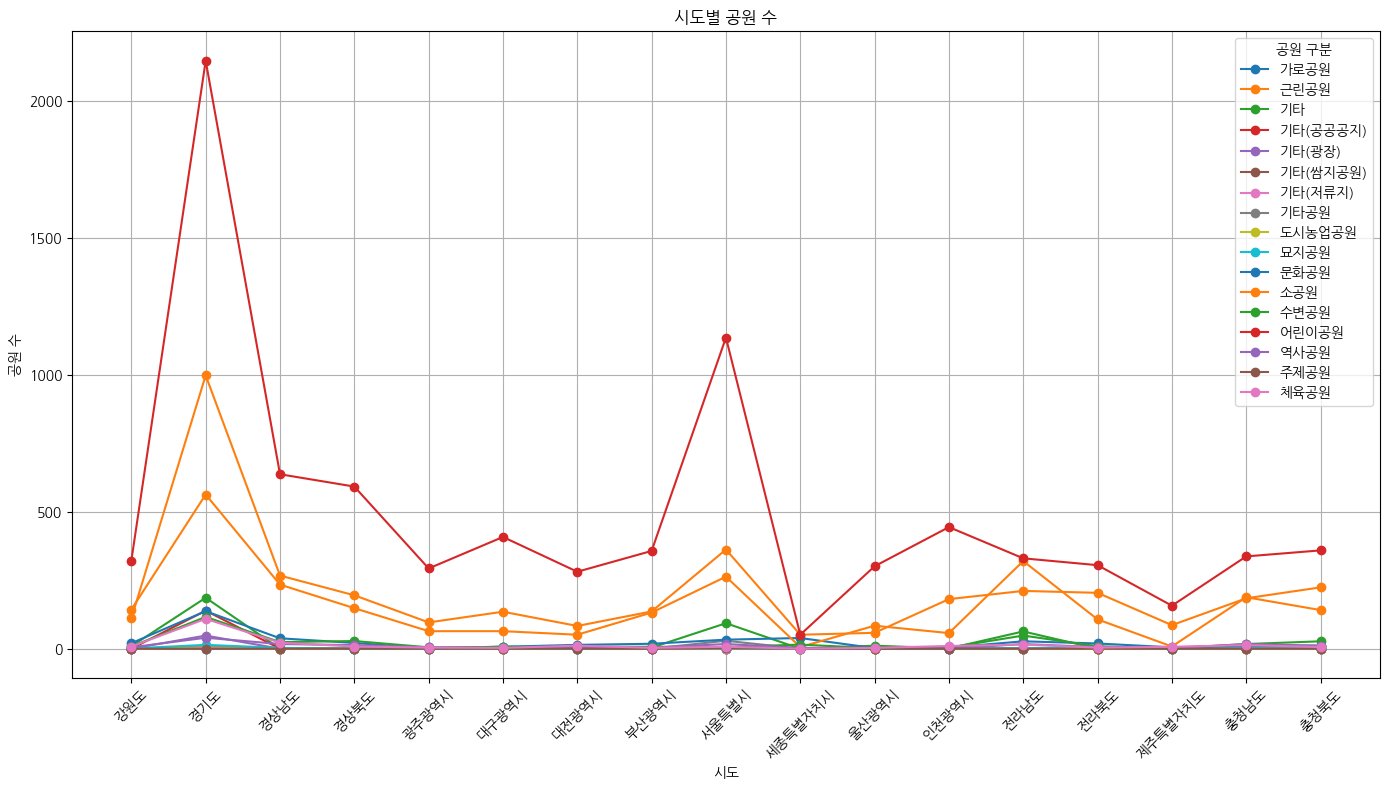

In [ ]:
#공원종류 구분
park['시도별'].replace('', pd.NA, inplace=True)

# NaN 값 제거
park.dropna(subset=['시도별'], inplace=True)

# 시도별 공원수를 계산
park_counts = park.groupby(['시도별', '공원구분']).size().unstack(fill_value=0)

# 시각화
plt.figure(figsize=(14, 8))

for park_type in park_counts.columns:
    plt.plot(park_counts.index, park_counts[park_type], label=park_type, marker='o')

plt.xlabel('시도')
plt.ylabel('공원 수')
plt.title('시도별 공원 수')
plt.xticks(rotation=45)
plt.legend(title='공원 구분')
plt.grid(True)
plt.tight_layout()

plt.show()

<Figure size 1400x700 with 0 Axes>

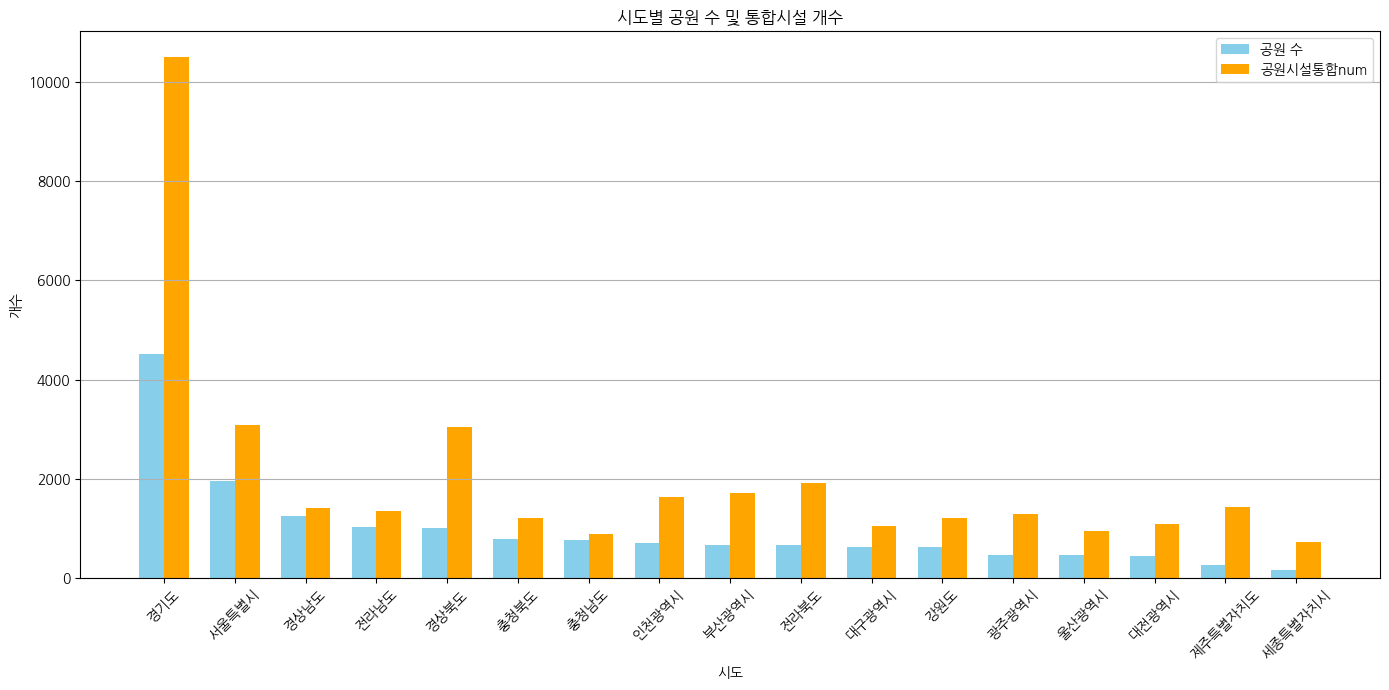

In [ ]:
park['시도별'].replace('', pd.NA, inplace=True)

# NaN 값 제거
park.dropna(subset=['시도별'], inplace=True)

# 시도별 공원 수 계산
province_park_counts = park['시도별'].value_counts().reset_index()
province_park_counts.columns = ['시도별', '공원수']

# 시도별 공원통합시설 개수 계산
province_facility_counts = park.groupby('시도별')['공원시설통합num'].sum().reset_index()
province_facility_counts.columns = ['시도별', '공원시설통합num']

# 공원 수와 통합시설 개수를 병합
merged_data = pd.merge(province_park_counts, province_facility_counts, on='시도별')

# 시각화
plt.figure(figsize=(14, 7))
x = np.arange(len(merged_data['시도별']))  # x축 위치
width = 0.35  # 막대 너비

fig, ax = plt.subplots(figsize=(14, 7))
bars1 = ax.bar(x - width/2, merged_data['공원수'], width, label='공원 수', color='skyblue')
bars2 = ax.bar(x + width/2, merged_data['공원시설통합num'], width, label='공원시설통합num', color='orange')

# 그래프 설정
ax.set_xlabel('시도')
ax.set_ylabel('개수')
ax.set_title('시도별 공원 수 및 통합시설 개수')
ax.set_xticks(x)
ax.set_xticklabels(merged_data['시도별'], rotation=45)
ax.legend()

# 레이아웃 조정
plt.tight_layout()
plt.grid(axis='y')
plt.show()

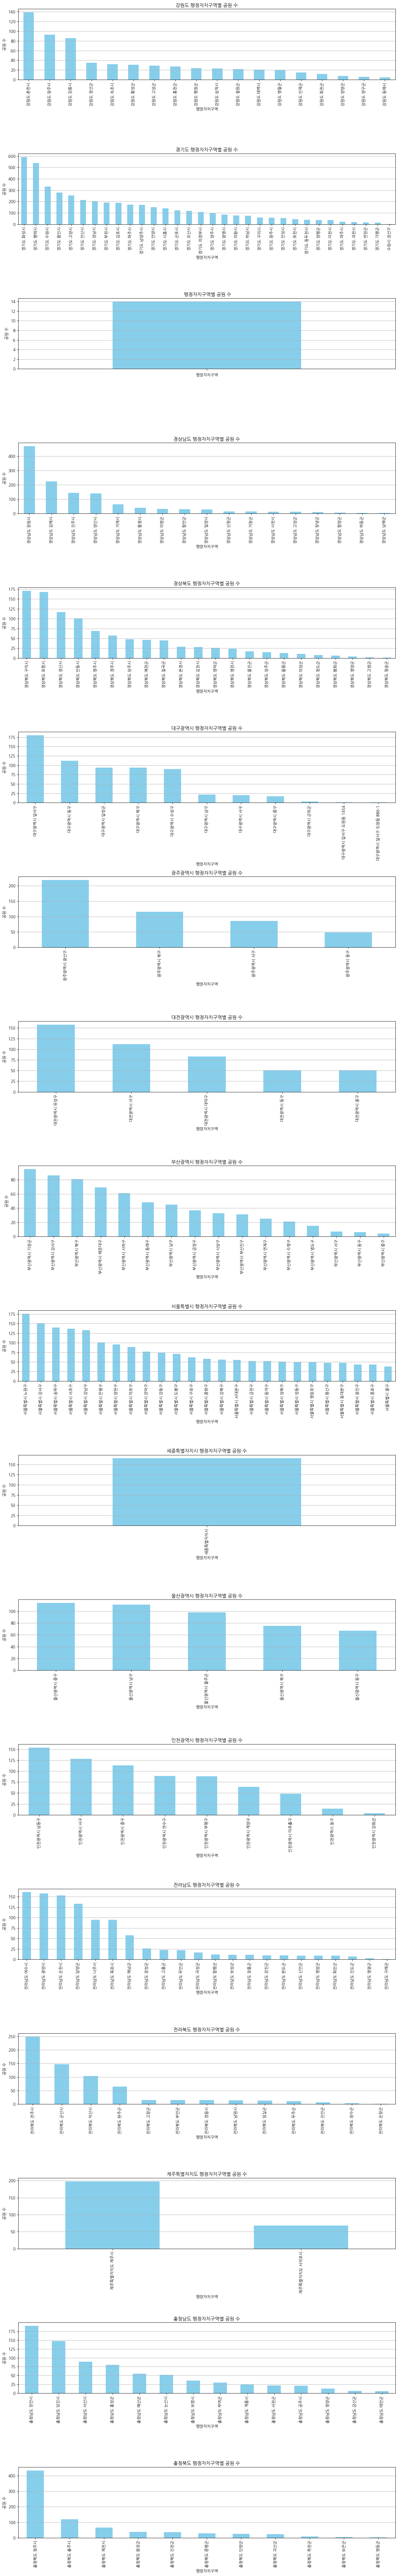

In [ ]:
# 행정자치구역별 공원 수 계산
district_park_counts = park['행정자치구역'].value_counts()

# 시도별로 행정자치구역 공원 수를 계산
unique_provinces = park['시도별'].unique()
num_provinces = len(unique_provinces)
fig, axes = plt.subplots(nrows=num_provinces, ncols=1, figsize=(14, num_provinces * 5))

for i, province in enumerate(unique_provinces):
    ax = axes[i]
    province_data = park[park['시도별'] == province]['행정자치구역'].value_counts()
    province_data.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(f'{province} 행정자치구역별 공원 수')
    ax.set_xlabel('행정자치구역')
    ax.set_ylabel('공원 수')
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

인구 당 공원 수

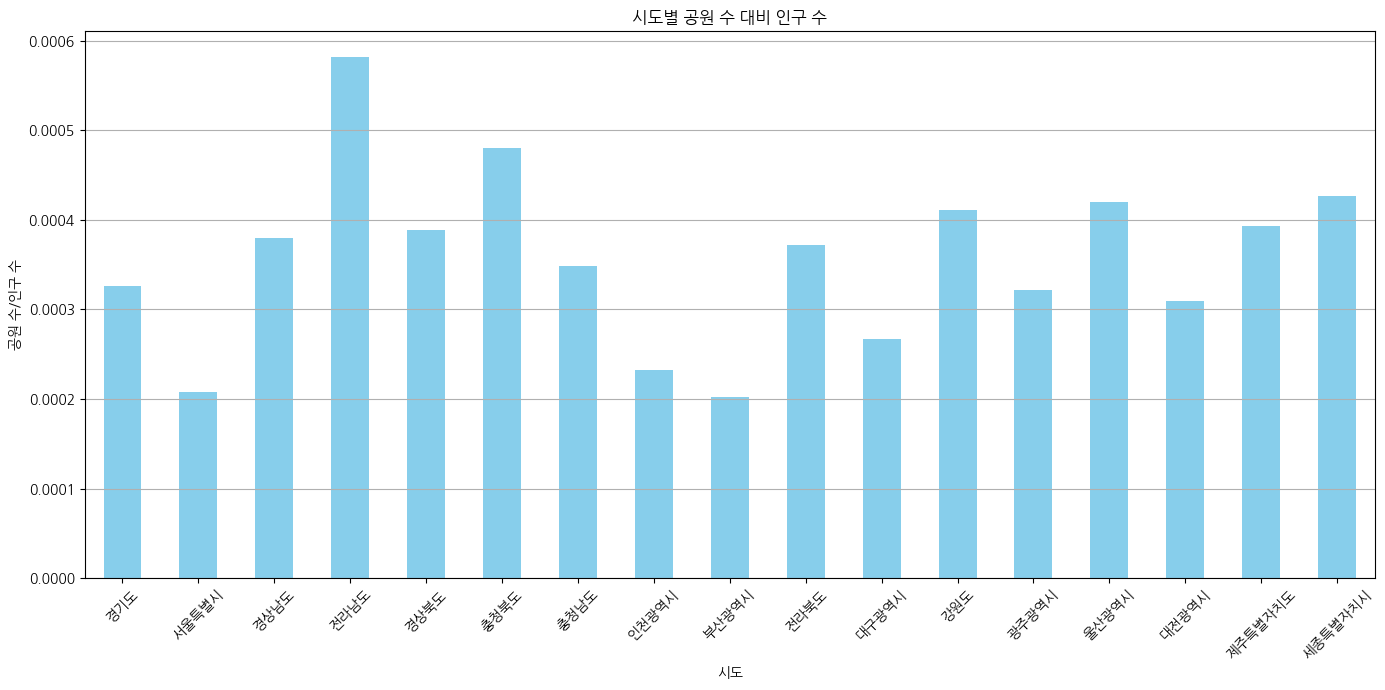

In [ ]:
# 인구 데이터프레임 열 이름 변경
pop.columns = ['시도별', '인구']

# 시도별 공원 수 계산
province_park_counts = park['시도별'].value_counts().reset_index()
province_park_counts.columns = ['시도별', '공원수']

# 공원 데이터와 인구 데이터를 병합
merged_data = pd.merge(province_park_counts, pop, on='시도별')

# 공원 수를 인구 수로 나눈 값 계산
merged_data['공원수/인구수'] = merged_data['공원수'] / merged_data['인구']

# 시각화
plt.figure(figsize=(14, 7))
merged_data.set_index('시도별')['공원수/인구수'].plot(kind='bar', color='skyblue')
plt.title('시도별 공원 수 대비 인구 수')
plt.xlabel('시도')
plt.ylabel('공원 수/인구 수')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

인구 당 시도별 공원 수, 시설 수

<Figure size 1400x700 with 0 Axes>

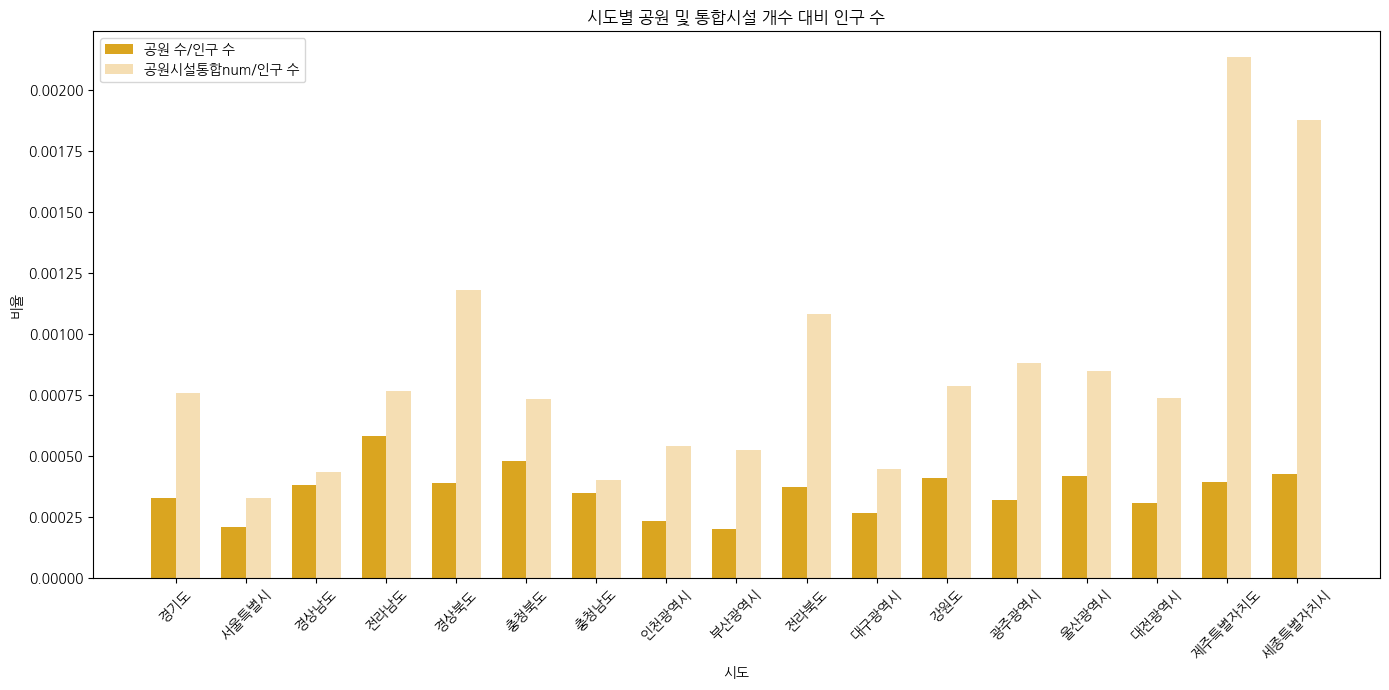

In [ ]:
# 인구 데이터프레임 열 이름 변경
pop.columns = ['시도별', '인구']

# 시도별 공원 수 계산
province_park_counts = park['시도별'].value_counts().reset_index()
province_park_counts.columns = ['시도별', '공원수']

# 시도별 공원통합시설 개수 계산
province_facility_counts = park.groupby('시도별')['공원시설통합num'].sum().reset_index()
province_facility_counts.columns = ['시도별', '공원시설통합num']

# 공원 수와 통합시설 개수를 병합
merged_data = pd.merge(province_park_counts, province_facility_counts, on='시도별')

# 공원 데이터와 인구 데이터를 병합
merged_data = pd.merge(merged_data, pop, on='시도별')

# 공원 수와 통합시설 개수를 각각 인구 수로 나눈 값 계산
merged_data['공원수/인구수'] = merged_data['공원수'] / merged_data['인구']
merged_data['공원시설통합num/인구수'] = merged_data['공원시설통합num'] / merged_data['인구']

# 시각화
plt.figure(figsize=(14, 7))
x = np.arange(len(merged_data['시도별']))  # x축 위치
width = 0.35  # 막대 너비

fig, ax = plt.subplots(figsize=(14, 7))
bars1 = ax.bar(x - width/2, merged_data['공원수/인구수'], width, label='공원 수/인구 수', color='goldenrod')
bars2 = ax.bar(x + width/2, merged_data['공원시설통합num/인구수'], width, label='공원시설통합num/인구 수', color='wheat')

# 그래프 설정
ax.set_xlabel('시도')
ax.set_ylabel('비율')
ax.set_title('시도별 공원 및 통합시설 개수 대비 인구 수')
ax.set_xticks(x)
ax.set_xticklabels(merged_data['시도별'], rotation=45)
ax.legend()

# 레이아웃 조정
plt.tight_layout()
#plt.grid(axis='y')
plt.show()

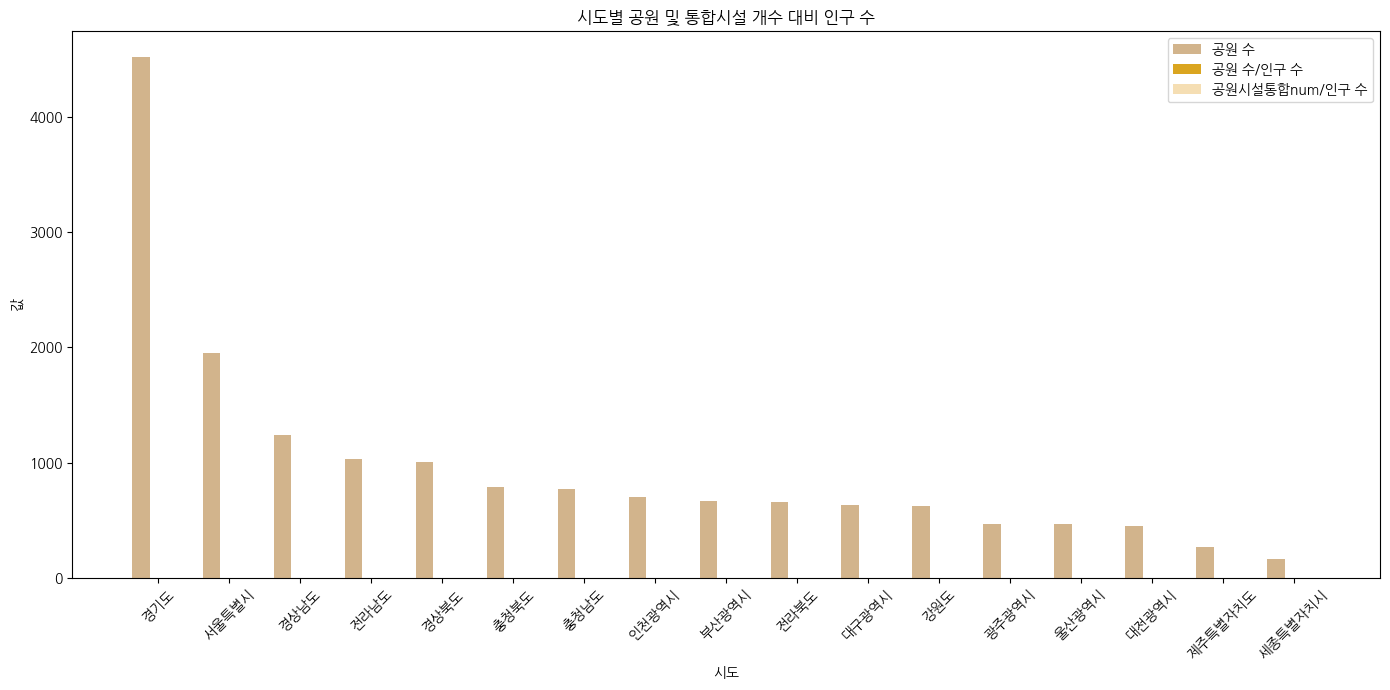

In [ ]:
# 인구 데이터프레임 열 이름 변경
pop.columns = ['시도별', '인구']

# 시도별 공원 수 계산
province_park_counts = park['시도별'].value_counts().reset_index()
province_park_counts.columns = ['시도별', '공원수']

# 시도별 공원시설통합시설 개수 계산
province_facility_counts = park.groupby('시도별')['공원시설통합num'].sum().reset_index()
province_facility_counts.columns = ['시도별', '공원시설통합num']

# 공원 수와 통합시설 개수를 병합
merged_data = pd.merge(province_park_counts, province_facility_counts, on='시도별')

# 공원 데이터와 인구 데이터를 병합
merged_data = pd.merge(merged_data, pop, on='시도별')

# 공원 수와 통합시설 개수를 각각 인구 수로 나눈 값 계산
merged_data['공원수/인구수'] = merged_data['공원수'] / merged_data['인구']
merged_data['공원시설통합num/인구수'] = merged_data['공원시설통합num'] / merged_data['인구']

# 시각화
x = np.arange(len(merged_data['시도별']))  # x축 위치
width = 0.25  # 막대 너비

fig, ax = plt.subplots(figsize=(14, 7))
bars1 = ax.bar(x - width, merged_data['공원수'], width, label='공원 수', color='tan')
bars2 = ax.bar(x, merged_data['공원수/인구수'], width, label='공원 수/인구 수', color='goldenrod')
bars3 = ax.bar(x + width, merged_data['공원시설통합num/인구수'], width, label='공원시설통합num/인구 수', color='wheat')

# 그래프 설정
ax.set_xlabel('시도')
ax.set_ylabel('값')
ax.set_title('시도별 공원 및 통합시설 개수 대비 인구 수')
ax.set_xticks(x)
ax.set_xticklabels(merged_data['시도별'], rotation=45)
ax.legend()

# 레이아웃 조정
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

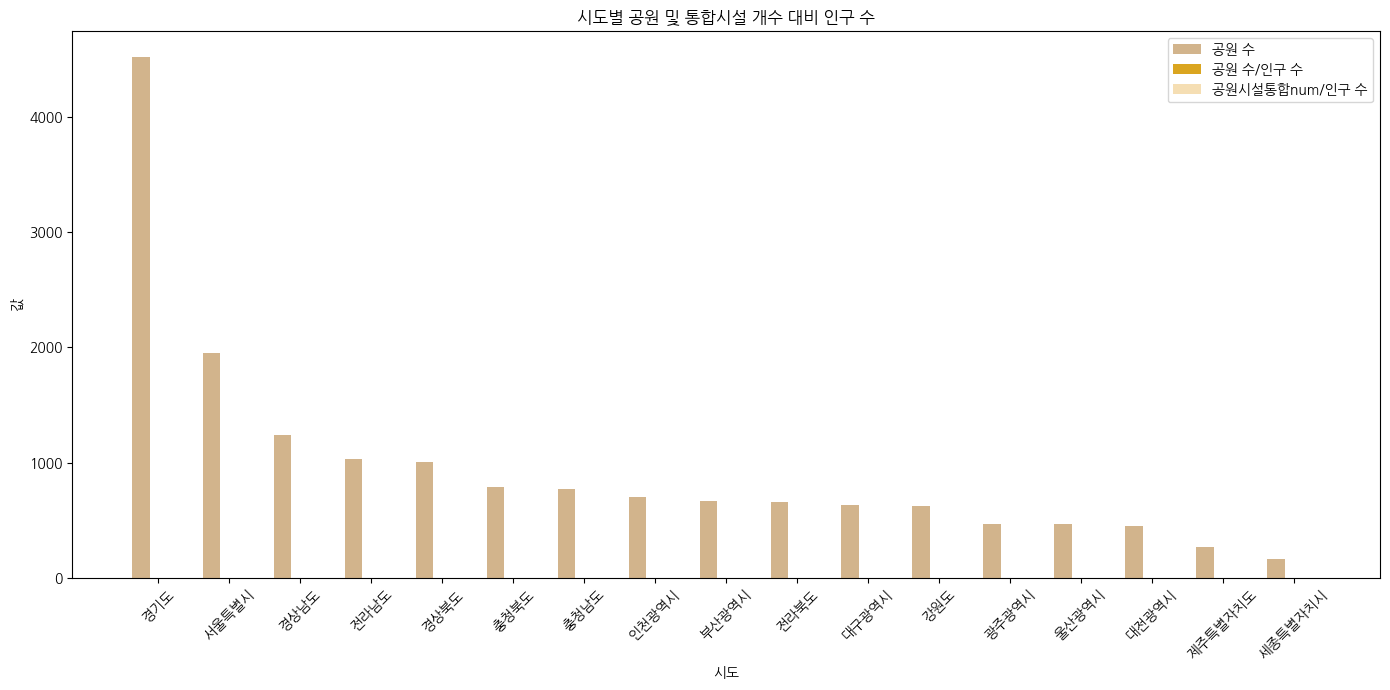

In [ ]:
# 인구 데이터프레임 열 이름 변경
pop.columns = ['시도별', '인구']

# 시도별 공원 수 계산
province_park_counts = park['시도별'].value_counts().reset_index()
province_park_counts.columns = ['시도별', '공원수']

# 시도별 공원시설통합시설 개수 계산
province_facility_counts = park.groupby('시도별')['공원시설통합num'].sum().reset_index()
province_facility_counts.columns = ['시도별', '공원시설통합num']

# 공원 수와 통합시설 개수를 병합
merged_data = pd.merge(province_park_counts, province_facility_counts, on='시도별')

# 공원 데이터와 인구 데이터를 병합
merged_data = pd.merge(merged_data, pop, on='시도별')

# 공원 수와 통합시설 개수를 각각 인구 수로 나눈 값 계산
merged_data['공원수/인구수'] = merged_data['공원수'] / merged_data['인구']
merged_data['공원시설통합num/인구수'] = merged_data['공원시설통합num'] / merged_data['인구']

# 시각화
plt.figure(figsize=(14, 7))
x = np.arange(len(merged_data['시도별']))  # x축 위치
width = 0.25  # 막대 너비

fig, ax = plt.subplots(figsize=(14, 7))
bars1 = ax.bar(x - width, merged_data['공원수'], width, label='공원 수', color='tan')
bars2 = ax.bar(x, merged_data['공원수/인구수'], width, label='공원 수/인구 수', color='goldenrod')
bars3 = ax.bar(x + width, merged_data['공원시설통합num/인구수'], width, label='공원시설통합num/인구 수', color='wheat')

# 그래프 설정
ax.set_xlabel('시도')
ax.set_ylabel('값')
ax.set_title('시도별 공원 및 통합시설 개수 대비 인구 수')
ax.set_xticks(x)
ax.set_xticklabels(merged_data['시도별'], rotation=45)
ax.legend()

# 레이아웃 조정
plt.tight_layout()
plt.show()

In [ ]:
merged_data.head()

,시도별,공원수,공원시설통합num,인구,공원수/인구수,공원시설통합num/인구수
0,경기도,4513,10498,13815367,0.000327,0.000760
1,서울특별시,1951,3086,9384512,0.000208,0.000329
2,경상남도,1242,1420,3271148,0.000380,0.000434
3,전라남도,1033,1359,1776668,0.000581,0.000765
4,경상북도,1006,3053,2589880,0.000388,0.001179


지정고시일(공원 생긴 시점) 시각화

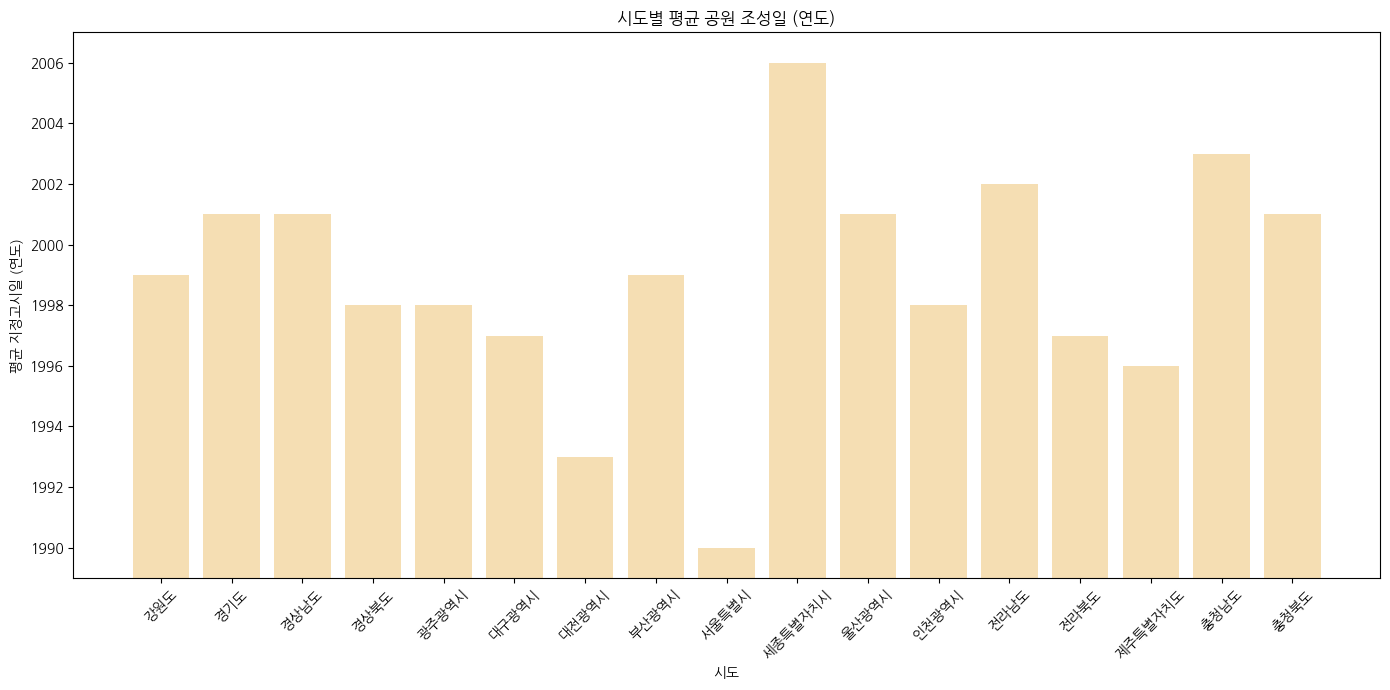

In [ ]:
# 빈 문자열을 NaN으로 변환
park['시도별'].replace('', pd.NA, inplace=True)

# NaN 값 제거
park.dropna(subset=['시도별'], inplace=True)

# '지정고시일' 열을 날짜 형식으로 변환
park['지정고시일'] = pd.to_datetime(park['지정고시일'], errors='coerce')

# 시도별 평균 지정고시일 계산
average_designation_date = park.groupby('시도별')['지정고시일'].mean().reset_index()

# 시각화를 위해 년도만 추출
average_designation_date['평균년도'] = average_designation_date['지정고시일'].dt.year

# 시각화
plt.figure(figsize=(14, 7))
plt.bar(average_designation_date['시도별'], average_designation_date['평균년도'], color='wheat')

# Y축 범위 조정
plt.ylim(average_designation_date['평균년도'].min() - 1, average_designation_date['평균년도'].max() + 1)

plt.title('시도별 평균 공원 조성일 (연도)')
plt.xlabel('시도')
plt.ylabel('평균 지정고시일 (연도)')
plt.xticks(rotation=45)
#plt.grid(axis='y')
plt.tight_layout()
plt.show()

##종속변수 데이터 불러오기 및 전처리

In [ ]:
sat=pd.read_csv("/content/drive/MyDrive/EDA 프로젝트 도시환경/삶의 만족도.csv",encoding='cp949')

In [ ]:
sat

,행정자치구역,매우 만족,약간 만족,보통,약간 불만족,매우 불만족
0,서울특별시,11.4,30.5,43.3,11.8,3.1
1,부산광역시,10.2,30.3,44.2,12.3,3.0
2,대구광역시,11.2,26.4,45.2,14.2,3.1
3,인천광역시,12.6,27.2,46.2,10.4,3.5
4,광주광역시,11.4,31.6,44.2,10.2,2.5
5,대전광역시,14.6,34.4,39.2,9.5,2.3
6,울산광역시,11.0,30.4,41.4,14.0,3.2
7,세종특별자치시,15.9,37.4,35.1,9.3,2.2
8,경기도,11.8,29.5,43.1,12.3,3.3
9,강원도,14.1,33.0,40.3,10.7,1.8


## 삶의 만족도

In [ ]:
#만족도 계산
sat['만족도'] = (
    sat['매우 만족'] * 5 +
    sat['약간 만족'] * 4 +
    sat['보통'] * 3 +
    sat['약간 불만족'] * 2 +
    sat['매우 불만족'] * 1
)

시도별 공원 수와 삶의 만족도 간 상관관계

In [ ]:
sat=sat.rename(columns={'행정자치구역':'시도별'})

상관관계: -0.24668661404508546


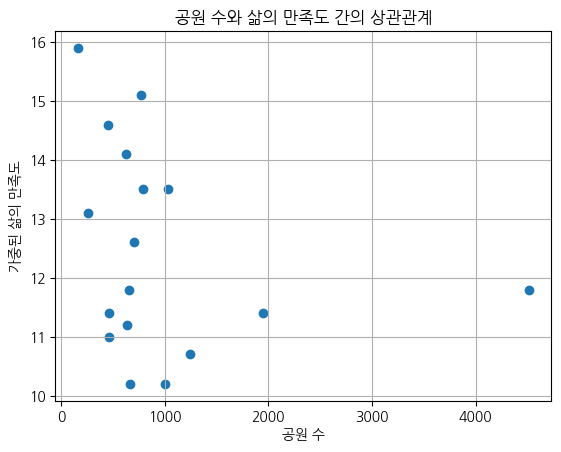

In [ ]:
# 시도별 공원 수 계산
park['시도별'] = park['시도별'].replace('', pd.NA)  # 빈 문자열을 NA로 변환
park.dropna(subset=['시도별'], inplace=True)  # NA 값을 가진 행 제거
province_park_counts = park['시도별'].value_counts().reset_index()
province_park_counts.columns = ['시도별', '공원수']

# 공원 데이터와 만족도 데이터를 병합
merged_data = pd.merge(province_park_counts, sat[['시도별', '매우 만족']], on='시도별')

# 상관관계 분석
correlation = merged_data['공원수'].corr(merged_data['매우 만족'])

# 결과 출력
print("상관관계:", correlation)

# 상관관계 시각화
plt.scatter(merged_data['공원수'], merged_data['매우 만족'])
plt.title('공원 수와 삶의 만족도 간의 상관관계')
plt.xlabel('공원 수')
plt.ylabel('가중된 삶의 만족도')
plt.grid(True)
plt.show()

상관관계: -0.3003568810366161


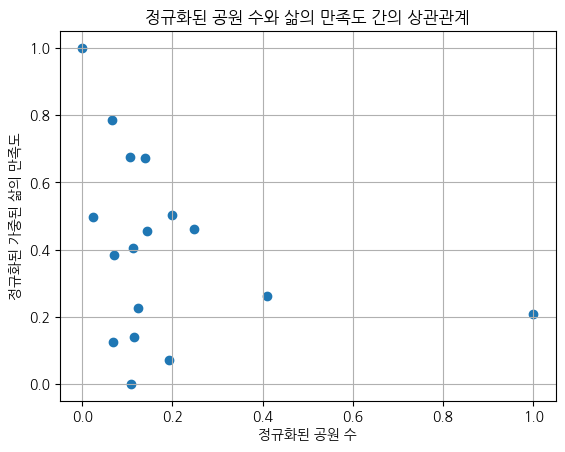

In [ ]:
# 시도별 공원 수 계산
park['시도별'] = park['시도별'].replace('', pd.NA)  # 빈 문자열을 NA로 변환
park.dropna(subset=['시도별'], inplace=True)  # NA 값을 가진 행 제거
province_park_counts = park['시도별'].value_counts().reset_index()
province_park_counts.columns = ['시도별', '공원수']

# 공원 데이터와 만족도 데이터를 병합
merged_data = pd.merge(province_park_counts, sat[['시도별', '만족도']], on='시도별')

# 데이터 스케일링
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(merged_data[['공원수', '만족도']])
merged_data['scaled_공원수'] = scaled_values[:, 0]
merged_data['scaled_만족도'] = scaled_values[:, 1]

# 상관관계 분석
correlation = merged_data['scaled_공원수'].corr(merged_data['scaled_만족도'])

# 결과 출력
print("상관관계:", correlation)

# 상관관계 시각화
plt.scatter(merged_data['scaled_공원수'], merged_data['scaled_만족도'])
plt.title('정규화된 공원 수와 삶의 만족도 간의 상관관계')
plt.xlabel('정규화된 공원 수')
plt.ylabel('정규화된 가중된 삶의 만족도')
plt.grid(True)
plt.show()

## 지역 내 총생산

지역내총생산(GRDP)은 일정기간동안 정해진 경제구역 내에서 생산된 모든 재화와 서비스의 시장가격 합이고, 지역총소득(GRI)은 경제구역내에서 주된 경제활동을 수행하는 거주자가 생산활동에 참여한 대가로 받은 소득의 합계를 의미합니다.

In [ ]:
gdp=pd.read_csv("/content/drive/MyDrive/EDA 프로젝트 도시환경/지역내총생산.csv",encoding='cp949')

In [ ]:
gdp

,시도별,1인당 지역내총생산,1인당 지역총소득,1인당 개인소득,1인당 민간소비
0,서울특별시,51612,57236,26112,24455
1,부산광역시,31611,32293,22577,20637
2,대구광역시,26736,31056,22368,19903
3,인천광역시,35295,37442,22406,18706
4,광주광역시,30900,34844,23669,20361
5,대전광역시,33682,35848,24220,21065
6,울산광역시,77511,60971,26066,21097
7,세종특별자치시,37875,41372,23215,18571
8,경기도,39969,43635,23136,19307
9,강원도,34426,33198,22395,18457


상관관계: 0.24787442464484796


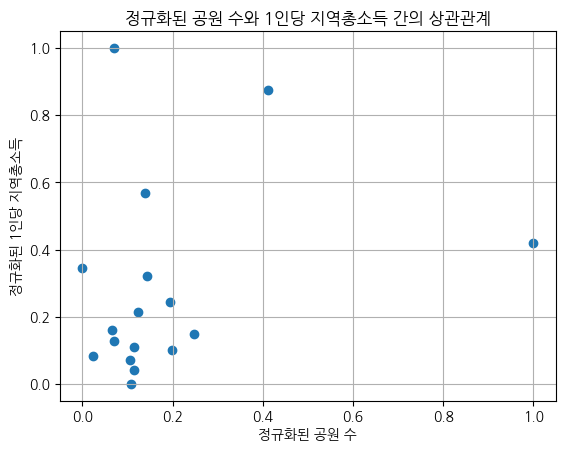

In [ ]:
# 시도별 공원 수 계산
park['시도별'] = park['시도별'].replace('', pd.NA)  # 빈 문자열을 NA로 변환
park.dropna(subset=['시도별'], inplace=True)  # NA 값을 가진 행 제거
province_park_counts = park['시도별'].value_counts().reset_index()
province_park_counts.columns = ['시도별', '공원수']

# 공원 데이터와 만족도 데이터를 병합
merged_data = pd.merge(province_park_counts, gdp[['시도별', '1인당 지역총소득']], on='시도별')

# 데이터 스케일링
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(merged_data[['공원수', '1인당 지역총소득']])
merged_data['scaled_공원수'] = scaled_values[:, 0]
merged_data['scaled_총소득'] = scaled_values[:, 1]

# 상관관계 분석
correlation = merged_data['scaled_공원수'].corr(merged_data['scaled_총소득'])

# 결과 출력
print("상관관계:", correlation)

# 상관관계 시각화
plt.scatter(merged_data['scaled_공원수'], merged_data['scaled_총소득'])
plt.title('정규화된 공원 수와 1인당 지역총소득 간의 상관관계')
plt.xlabel('정규화된 공원 수')
plt.ylabel('정규화된 1인당 지역총소득')
plt.grid(True)
plt.show()

상관관계: 0.07424506073650536


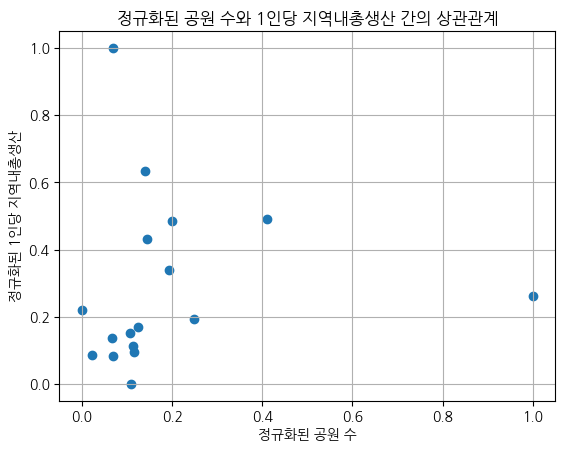

In [ ]:
# 시도별 공원 수 계산
park['시도별'] = park['시도별'].replace('', pd.NA)  # 빈 문자열을 NA로 변환
park.dropna(subset=['시도별'], inplace=True)  # NA 값을 가진 행 제거
province_park_counts = park['시도별'].value_counts().reset_index()
province_park_counts.columns = ['시도별', '공원수']

# 공원 데이터와 만족도 데이터를 병합
merged_data = pd.merge(province_park_counts, gdp[['시도별', '1인당 지역내총생산']], on='시도별')

# 데이터 스케일링
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(merged_data[['공원수', '1인당 지역내총생산']])
merged_data['scaled_공원수'] = scaled_values[:, 0]
merged_data['scaled_총생산'] = scaled_values[:, 1]

# 상관관계 분석
correlation = merged_data['scaled_공원수'].corr(merged_data['scaled_총생산'])

# 결과 출력
print("상관관계:", correlation)

# 상관관계 시각화
plt.scatter(merged_data['scaled_공원수'], merged_data['scaled_총생산'])
plt.title('정규화된 공원 수와 1인당 지역내총생산 간의 상관관계')
plt.xlabel('정규화된 공원 수')
plt.ylabel('정규화된 1인당 지역내총생산')
plt.grid(True)
plt.show()

지정고시일 열 추가

In [ ]:
# 빈 문자열을 NaN으로 변환
park['시도별'].replace('', pd.NA, inplace=True)

# NaN 값 제거
park.dropna(subset=['시도별'], inplace=True)

# '지정고시일' 열을 날짜 형식으로 변환
park['지정고시일'] = pd.to_datetime(park['지정고시일'], errors='coerce')

# 시도별 평균 지정고시일 계산
average_designation_date = park.groupby('시도별')['지정고시일'].mean().reset_index()

# 시각화를 위해 년도만 추출
average_designation_date['평균년도'] = average_designation_date['지정고시일'].dt.year

# 먼저, 평균년도를 시도별로 매핑하기 위한 사전 생성
year_map = average_designation_date.set_index('시도별')['평균년도'].to_dict()

# park 데이터에 '평균년도' 열 추가
park['평균년도'] = park['시도별'].map(year_map)

In [ ]:
park.head()

,공원명,공원구분,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,행정자치구역,시도별,공원시설통합,공원시설통합num,평균년도
0,봉화산2지구2(3호),근린공원,37.353826,127.921297,33036.0,NaN,NaN,NaN,NaN,NaN,2009-11-20,강원도 원주시청,강원도 원주시,강원도,,0,1999
1,단구공원,근린공원,37.326433,127.953644,290813.0,농구장+배드민턴장,NaN,NaN,NaN,NaN,1967-04-19,강원도 원주시청,강원도 원주시,강원도,농구장+배드민턴장,2,1999
2,호국(태장2호)공원,근린공원,37.365319,127.952681,33539.0,NaN,NaN,NaN,NaN,NaN,1967-04-19,강원도 원주시청,강원도 원주시,강원도,,0,1999
3,단계조각(단계3호)공원,근린공원,37.340966,127.935690,22216.0,풋살경기장,NaN,NaN,청소년도서관+체육관,NaN,1974-11-26,강원도 원주시청,강원도 원주시,강원도,풋살경기장+청소년도서관+체육관,3,1999
4,일산공원,근린공원,37.346851,127.937280,21182.0,NaN,NaN,NaN,NaN,NaN,1974-11-26,강원도 원주시청,강원도 원주시,강원도,,0,1999


총소득과 상관관계 행렬 그리기

In [ ]:
import seaborn as sns

<ipython-input-28-ffb73cff1c72>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  park['공원수'] = park.groupby('시도별')['시도별'].transform('count')
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


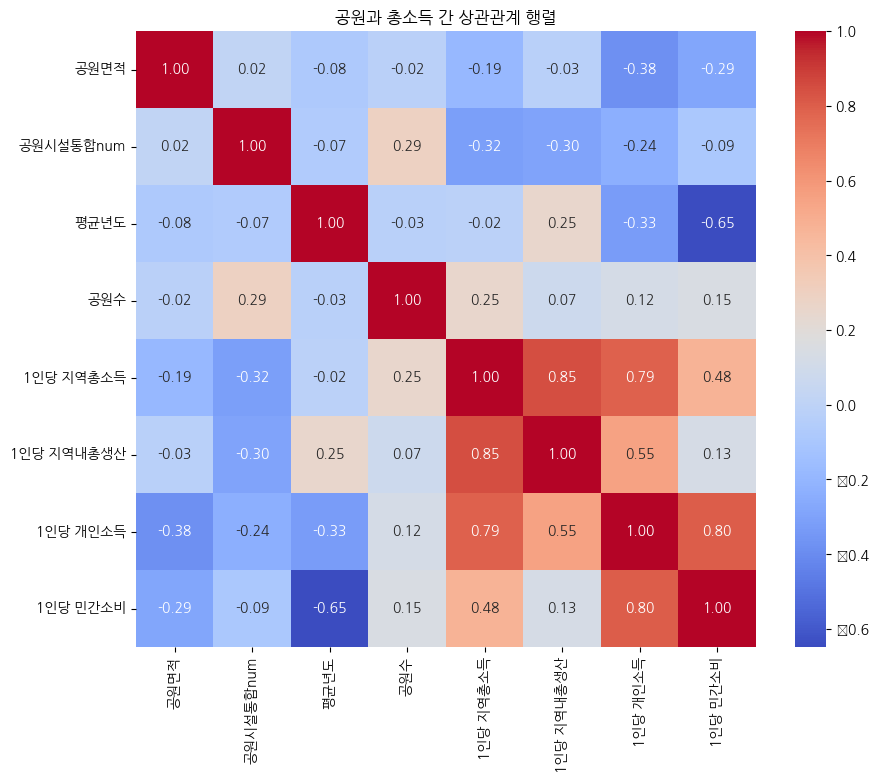

In [ ]:
# park 데이터에서 필요한 열 선택
park = park[['시도별', '공원면적', '공원시설통합num', '평균년도']]
park['공원수'] = park.groupby('시도별')['시도별'].transform('count')

# gdp 데이터에서 필요한 열 선택
gdp = gdp[['시도별', '1인당 지역총소득', '1인당 지역내총생산', '1인당 개인소득', '1인당 민간소비']]

# 데이터 병합
merged_data = pd.merge(park.drop_duplicates(subset=['시도별']), gdp, on='시도별', how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(merged_data.iloc[:, 1:])  # '시도별' 열 제외
normalized_df = pd.DataFrame(normalized_data, columns=merged_data.columns[1:])

# 상관관계 행렬 계산
correlation_matrix = normalized_df.corr()

# 상관관계 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('공원과 총소득 간 상관관계 행렬')
plt.show()

회귀분석 letsgo

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro

<ipython-input-30-8a4327d41d54>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  park['공원수'] = park.groupby('시도별')['시도별'].transform('count')  # 각 시도별 공원수 계산
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


                            OLS Regression Results                            
Dep. Variable:                    공원수   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9820
Date:                Thu, 01 Aug 2024   Prob (F-statistic):              0.337
Time:                        10:34:45   Log-Likelihood:                -140.54
No. Observations:                  17   AIC:                             285.1
Df Residuals:                      15   BIC:                             286.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -178.4248   1179.645     -0.151      0.8

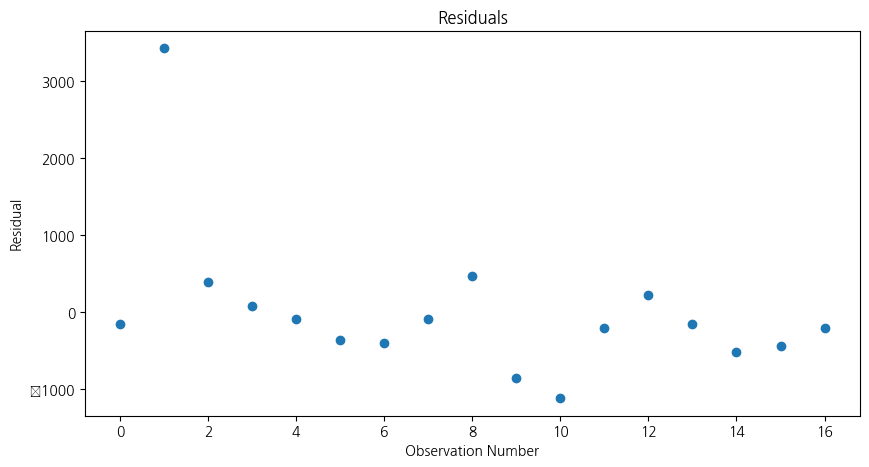

Breusch-Pagan test for heteroscedasticity p-value: 0.40967625739401226


In [ ]:
# 공원 데이터에서 필요한 열 선택 및 '공원수' 계산
park = park[['시도별', '공원면적']]
park['공원수'] = park.groupby('시도별')['시도별'].transform('count')  # 각 시도별 공원수 계산

# gdp 데이터에서 필요한 열 선택
gdp = gdp[['시도별', '1인당 지역총소득']]

# 데이터 병합
merged_data = pd.merge(park.drop_duplicates(subset=['시도별']), gdp, on='시도별', how='inner')

# 선형 회귀 모델 준비
X = merged_data['1인당 지역총소득']  # 독립 변수
y = merged_data['공원수']  # 종속 변수
X = sm.add_constant(X)  # 상수항 추가

# 선형 회귀 모델 피팅
model = sm.OLS(y, X).fit()

# 모델 요약 출력
print(model.summary())

# 잔차 분석
residuals = model.resid

# 잔차의 정규성 검정
print("Shapiro-Wilk test for normality:", shapiro(residuals))

# 잔차의 독립성 검정
plt.figure(figsize=(10, 5))
plt.plot(residuals, marker='o', linestyle='')
plt.title('Residuals')
plt.xlabel('Observation Number')
plt.ylabel('Residual')
plt.show()

# 잔차의 등분산성 검정
_, pvalue, _, _ = het_breuschpagan(residuals, X)
print("Breusch-Pagan test for heteroscedasticity p-value:", pvalue)

##통합 데이터 EDA

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
total=pd.read_csv("/content/drive/MyDrive/EDA 프로젝트 도시환경/[최종]공원+교육+문화시설+의료시설+종속변수 데이터.csv",encoding='cp949')

In [ ]:
total.head()

,시도,행정구,삶의 만족도,1인당 GRDP,신혼부부수,평균 자살율,평균 소득,미술관,도서관,박물관,...,여자_약국,여자_요양병원,여자_의원,여자_정신병원,여자_조산원,여자_종합병원,여자_치과병원,여자_치과의원,여자_한방병원,여자_한의원
0,충북,청주시,0.2927,4056.0,19299,23.4,37455.0,9.0,19.0,11.0,...,349.981493,11.205127,473.078018,3.067270,1.063807,5.649461,2.562182,250.398845,7.420389,208.875941
1,경기,남양주시,0.3529,1762.0,15517,21.4,37261.0,4.0,13.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,세종,세종특별자치시,0.9077,NaN,10959,NaN,NaN,NaN,NaN,NaN,...,78.042892,2.081144,107.178905,0.520286,0.000000,1.040572,0.520286,50.467737,1.560858,43.183734
3,서울,종로구,0.4437,22977.0,2043,15.7,42022.0,18.0,7.0,38.0,...,234.297928,1.370163,274.032665,0.000000,0.000000,2.740327,1.370163,190.452702,2.740327,154.828456
4,서울,중구,0.4976,44764.0,2582,20.2,38282.0,3.0,9.0,17.0,...,255.357662,0.000000,407.279310,0.000000,0.000000,1.616188,8.080939,320.005172,1.616188,151.921647


In [ ]:
total=total[['미술관','박물관','도서관']].fillna(0.0)
total[['미술관','박물관','도서관']]

,미술관,박물관,도서관
0,9.0,11.0,19.0
1,4.0,7.0,13.0
2,0.0,0.0,0.0
3,18.0,38.0,7.0
4,3.0,17.0,9.0
...,...,...,...
224,0.0,0.0,0.0
225,12.0,31.0,11.0
226,0.0,0.0,0.0
227,0.0,0.0,0.0


##LGBM

신혼부부수

In [ ]:
# 종속 변수와 독립 변수 정의 (예: '평균 소득'을 예측)
target_variable = '신혼부부수'
features = total.drop(columns=[target_variable, '시도', '행정구'])  # 시도 및 행정구 제거

# 종속 변수와 독립 변수 분리
X = features
y = total[target_variable]

# 학습용 및 테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# LightGBM 하이퍼파라미터 설정
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# 모델 학습
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data]
)

# 특징 중요도 계산
importance = gbm.feature_importance()
feature_names = X.columns

# 중요도 데이터프레임 생성
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in LightGBM')
plt.gca().invert_yaxis()
plt.show()

KeyError: '신혼부부수'

##PCA

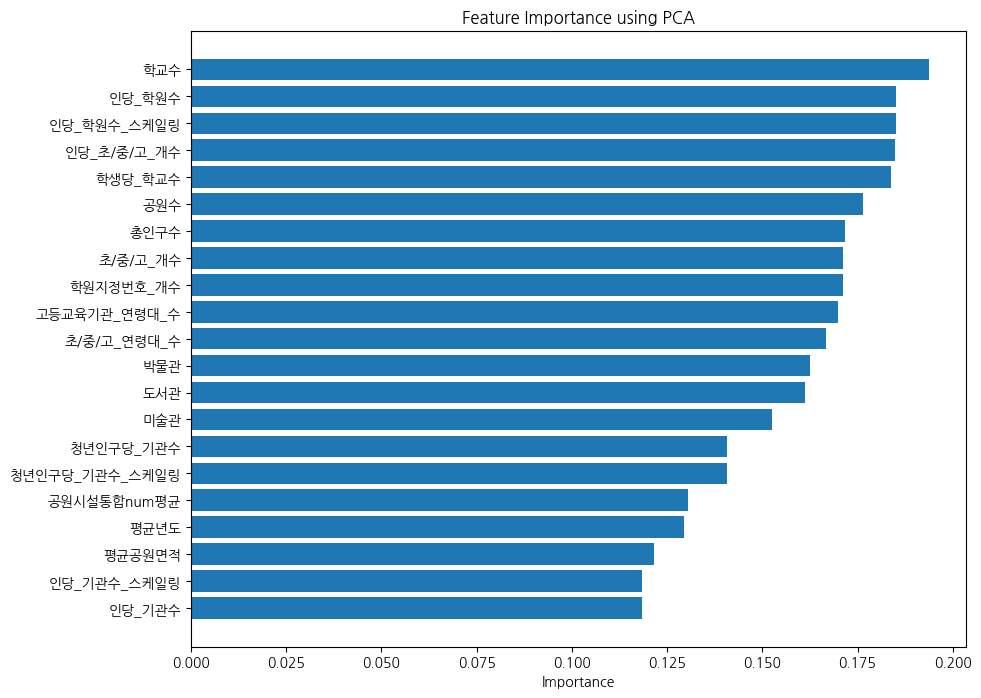

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 결측값 처리 (예: 평균 또는 중앙값으로 채우기)
numeric_cols = total.select_dtypes(include=[np.number]).columns
total[numeric_cols] = total[numeric_cols].fillna(total[numeric_cols].mean())

# 범주형 데이터: 최빈값으로 대체
categorical_cols =total.select_dtypes(include=['object']).columns
total[categorical_cols] =total[categorical_cols].fillna(total[categorical_cols].mode().iloc[0])

# 종속 변수 제거 (여기서는 '평균 소득'을 예로 들었습니다)
features = total.drop(columns=['1인당 GRDP','신혼부부수','평균 자살율','평균 소득', '시도', '행정구'])

# 데이터 표준화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# PCA 적용
pca = PCA(n_components=min(len(features.columns), len(features)))
pca.fit(scaled_features)

# 각 주성분의 분산 비율
explained_variance = pca.explained_variance_ratio_

# 주성분에 대한 각 특징의 중요도(계수 절대값의 합계 사용)
loadings = np.abs(pca.components_)

# 각 특징의 중요도를 합산
feature_importance = np.sum(loadings * explained_variance.reshape(-1, 1), axis=0)

# 중요도 데이터프레임 생성
importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance using PCA')
plt.gca().invert_yaxis()
plt.show()
